In [ ]:
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from torchvision.models import VGG13_BN_Weights, vgg13_bn
from tqdm import tqdm

DEVICE = "cuda"
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def save_img(image, path):
    # Push to CPU, convert from (1, 3, H, W) into (H, W, 3)
    image = image[0].permute(1, 2, 0)
    image = image.clamp(min=0, max=1)
    image = (image * 255).cpu().detach().numpy().astype(np.uint8)
    # opencv expects BGR (and not RGB) format
    cv.imwrite(path, image[:, :, ::-1])


def main():
    model = vgg13_bn(VGG13_BN_Weights.IMAGENET1K_V1).to(DEVICE)
    print(model)
    for label in [0, 12, 954]:
        image = torch.randn(1, 224, 224, 3).to(DEVICE)
        image = (image * 8 + 128) / 255  # background color = 128,128,128
        image = image.permute(0, 3, 1, 2)
        image.requires_grad_()
        image = gradient_descent(image, model, lambda tensor: tensor[0, label].mean(),)
        save_img(image, f"./img_{label}.jpg")
        out = model(image)
        print(f"ANSWER_FOR_LABEL_{label}: {out.softmax(1)[0, label].item()}")




from torchvision.transforms import v2
LR = 10.
GD_ITERATIONS = 1024 # gradient descent iterations per size
SCALING_ITERATIONS = 5 # number of times we scale up the image
SCALING_RATIO = 1.5 # how much the image will increase
LOG_FREQ = 100


def normalize_and_jitter(img, step=32):
    # You should use this as data augmentation and normalization,
    # convnets expect values to be mean 0 and std 1
    dx, dy = np.random.randint(-step, step - 1, 2)
    return transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)(
        img.roll(dx, -1).roll(dy, -2)
    )


def denormalize(img):
    mean = torch.tensor(IMAGENET_MEAN, device=DEVICE).reshape(1, 3, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=DEVICE).reshape(1, 3, 1, 1)
    img = (img * std) + mean  # de-normalize
    img = torch.clamp(img, min=0., max=1.)  # make sure it's in the [0, 1] range
    return img


def resize_image(img, ratio):
	prev_size = img.shape[-1]
	next_size = int(prev_size * ratio)
	img_np = img.permute(0, 2, 3, 1).contiguous().cpu().detach().numpy().reshape(prev_size, prev_size, 3)
	img_np = cv.resize(img_np, (next_size, next_size), interpolation=cv.INTER_CUBIC).reshape(1, next_size, next_size, 3)
	return torch.tensor(img_np, device=DEVICE, dtype=img.dtype).permute(0, 3, 1, 2).contiguous().requires_grad_()


def gradient_descent(input, model, loss, iterations=GD_ITERATIONS):
    model.eval()

    blurrer = v2.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 5.))

    input.data = normalize_and_jitter(input.data)
    for s in range(SCALING_ITERATIONS):
        for i in range(iterations):
            output, activations = forward_and_return_activation(model, input)
            # act_loss = torch.stack([torch.norm(torch.flatten(a)) for a in activations]).mean()
            l = loss(output)
            l.backward()
            input.data = input.data + (LR * blurrer(input.grad.data))
            input.data = torch.clamp(input.data, min=0., max=1.)
            if i % LOG_FREQ == 0:
                print(f"Scaling ({s+1}/{SCALING_ITERATIONS}) [{i+1}/{iterations}] loss: {l.item()}")
            if i+1 < iterations:
                input.data = blurrer(input.data)
            input.grad.data.zero_()

        print(f"Scaling ({s+1}/{SCALING_ITERATIONS}) [{i+1}/{iterations}] loss: {l.item()}")

        if s+1 < SCALING_ITERATIONS:
            input = resize_image(input, SCALING_RATIO)

    # input.data = denormalize(input.data)
    print(f"Scaling ({s+1}/{SCALING_ITERATIONS}) [{i+1}/{iterations}] loss: {l.item()}")
    return input


def forward_and_return_activation(model, input):
    activations = []
    handles = []
    layers = [19, 23, 26, 30, 33, 34]

    def hook(_, __, output):
        activations.append(output)
    for l in layers:
        handles.append(model.features[l].register_forward_hook(hook))
    output= model(input)
    for h in handles:
        h.remove()

    return output, activations


if __name__ == "__main__":
    main()




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth
100%|██████████| 508M/508M [00:06<00:00, 77.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Generated images for the following ImageNet classes:
Label 0: tench, Tinca tinca
Label 12: house finch, linnet, Carpodacus mexicanus
Label 954: banana


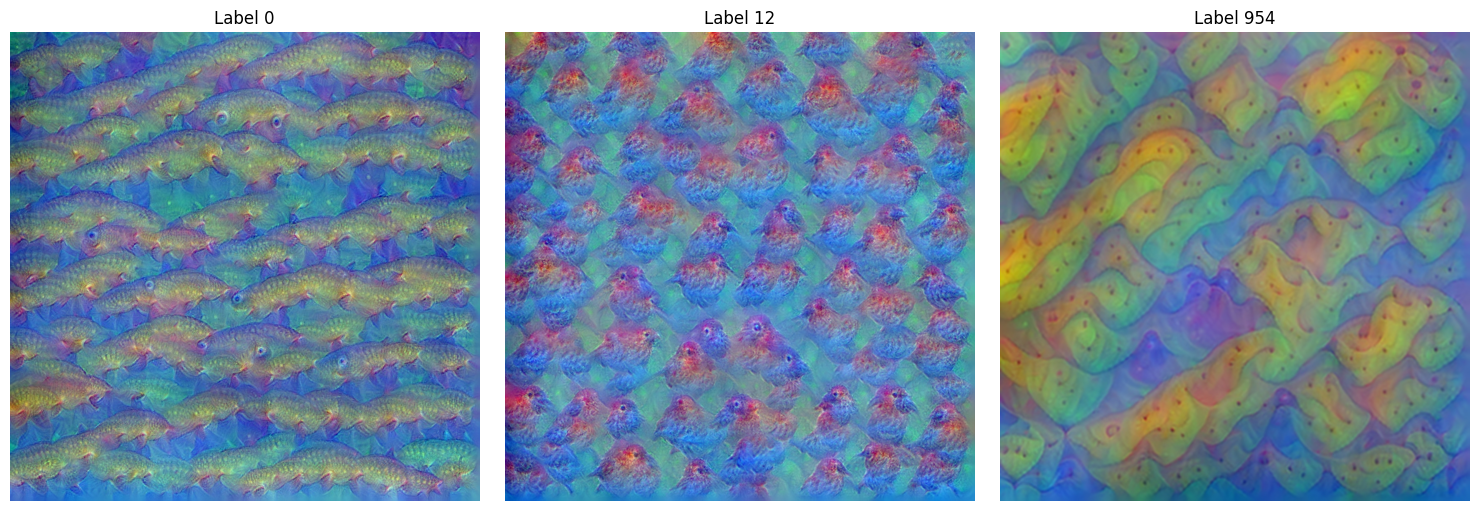

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

def display_generated_images():
    # List of labels we generated images for
    labels = [0, 12, 954]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))

    for idx, label in enumerate(labels):
        # Read the image
        img_path = f'img_{label}.jpg'
        img = cv2.imread(img_path)

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        axes[idx].imshow(img)
        axes[idx].set_title(f'Label {label}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Display ImageNet class labels for reference
imagenet_labels = {
    0: 'tench, Tinca tinca',
    12: 'house finch, linnet, Carpodacus mexicanus',
    954: 'banana'
}

print("Generated images for the following ImageNet classes:")
for label, name in imagenet_labels.items():
    print(f"Label {label}: {name}")

# Display the images
display_generated_images()